In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
# Connect to a database. Available here: http://astro-lsst-01.astro.washington.edu:8080/
dbFile = 'baseline_nexp2_v1.6_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)


In [3]:
bundleList = []
# Note I'm putting a depth cut on here so we don't count any very shallow images (e.g., taken in twilight)
sql = 'filter="r" and fiveSigmaDepth > 23.75'
metric = metrics.MinMetric(col='observationStartMJD')
slicer = slicers.HealpixSlicer(nside=128)
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))

# Let's just get a count of all observations while we're at it
sql=''
metric=metrics.CountMetric(col='night', units='N')
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Querying database SummaryAllProps with no constraint for columns ['fieldDec', 'fieldRA', 'night'].
Found 2064854 visits
Running:  ['opsim_Count_night_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="r" and fiveSigmaDepth > 23.75 for columns ['fieldDec', 'observationStartMJD', 'fieldRA']
Found 349832 visits
Running:  ['opsim_Min_observationStartMJD_r_and_fiveSigmaDepth_gt_23_75_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 839 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 647.119  dipole: lon: 67.0859, lat: -76.3256, amp: 239.001
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="r" and fiveSigmaDepth > 23.75" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 737 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 60013  dipole: lon: -122.263, lat: 49.092, amp: 170.746
  mono, lon, lat, amp


Plotting complete.


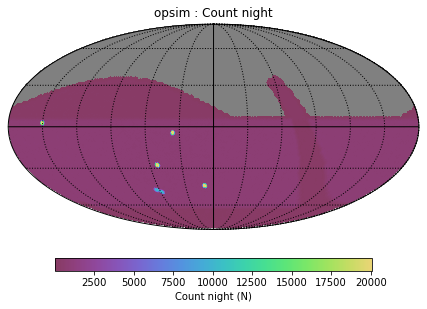

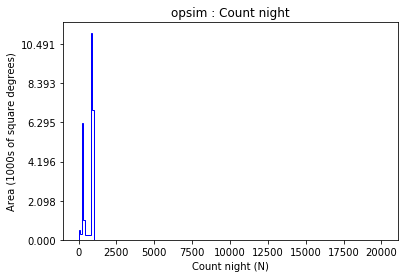

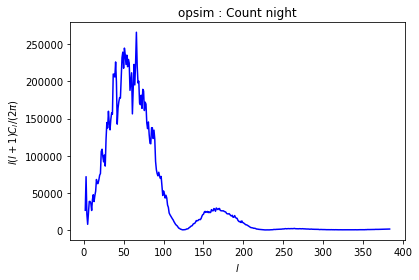

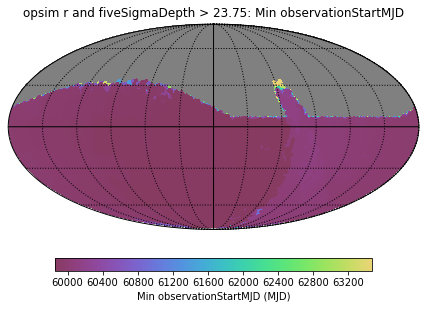

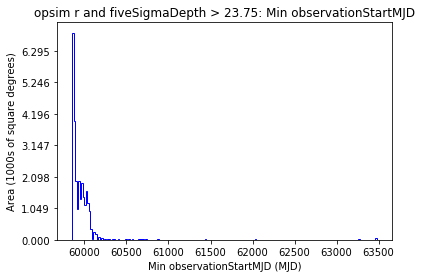

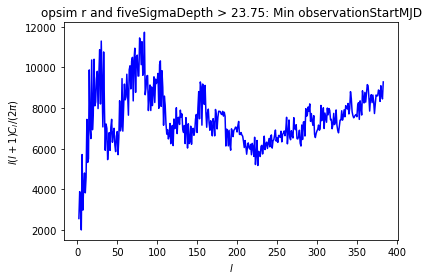

In [4]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [5]:
# Only include parts of the footprint that get observed a lot (cuts out pixels that were observed becuase of dithers)
good_vals = np.where(bundleList[1].metricValues > 100)[0]
good_vals.size, np.unique(bundleList[0].metricValues[good_vals]).size

(127798, 5413)

In [6]:
# Select a random 1000 points from the well-observed footprint
np.random.seed(42)
N = 1000
np.random.choice(bundleList[0].metricValues[good_vals], N)

array([6.00012297e+04, 5.99612590e+04, 6.07022046e+04, 6.00364120e+04,
       6.00302431e+04, 5.98650690e+04, 5.98651419e+04, 5.98762493e+04,
       5.98752120e+04, 5.98679944e+04, 5.99903818e+04, 6.00643026e+04,
       6.00333314e+04, 5.99342466e+04, 5.98742197e+04, 6.00023910e+04,
       5.99102158e+04, 5.98822941e+04, 5.98703517e+04, 5.99693755e+04,
       5.99280798e+04, 5.99913850e+04, 5.98670089e+04, 6.00354116e+04,
       5.98713213e+04, 6.00194006e+04, 5.99332447e+04, 5.98680388e+04,
       5.98732842e+04, 5.98763601e+04, 6.00574109e+04, 5.99903754e+04,
       5.98640075e+04, 5.99453479e+04, 5.99000592e+04, 6.00003599e+04,
       5.99633259e+04, 5.98750724e+04, 5.98661038e+04, 5.98563521e+04,
       5.98992182e+04, 5.99672523e+04, 5.98753120e+04, 5.99453516e+04,
       5.99003465e+04, 5.99003506e+04, 6.00603988e+04, 6.00012252e+04,
       6.00213978e+04, 5.98712345e+04, 5.99373458e+04, 5.99733567e+04,
       5.99383264e+04, 5.98752142e+04, 5.98710041e+04, 5.99381492e+04,
      